In [50]:
import os
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Activation,Dropout,Flatten,Dense
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
import numpy as np
import PIL
import keras

In [51]:
#设置显卡使用情况和限制显存使用情况
# 指定第一块GPU可用 
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1,2" #Titan XP
config = tf.ConfigProto()  
config.gpu_options.allow_growth=True   #不全部占满显存, 按需分配
sess = tf.Session(config=config)


In [55]:
# VGG16 : 太容易过拟合 先不用
model = Sequential()
model.add(VGG16(weights='imagenet',include_top=False, input_shape=(512,512,3)))
model.add(Flatten(input_shape=vgg16_model.output_shape[1:]))
model.add(Dense(50,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

# #3层卷积
# imgSize = 512  #图片尺寸
# imgChan = 1    #1通道
# kernelInit = 'uniform'  #卷积核初始化方式
# nHiddenUnits = 50
# maxpoolSize = (2,2)
# nFilters = 100 #130 before 
# kernelSize = (6,6)
# inputStrides = 1
# costFunction = 'categorical_crossentropy' #代价函数:不同于损失函数，代价函数在整个训练集上计算
# early_stop_delta = 0.01 # 0.01 change or above is considered improvement
# early_stop_patience = 10 

# model=Sequential()

# model.add(Conv2D(filters=nFilters, kernel_size = kernelSize ,strides= inputStrides,
#                  input_shape=(imgSize,imgSize,3),kernel_initializer= kernelInit))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=maxpoolSize))


# model.add(Conv2D(filters=nFilters, kernel_size = kernelSize ,strides= inputStrides,
#                  kernel_initializer= kernelInit))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=maxpoolSize))


# model.add(Conv2D(filters=nFilters, kernel_size = kernelSize ,strides= inputStrides,
#                  kernel_initializer= kernelInit))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=maxpoolSize))

# model.add(Conv2D(filters=nFilters, kernel_size = kernelSize ,strides= inputStrides,
#                  kernel_initializer= kernelInit))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=maxpoolSize))

# model.add(Flatten())
# model.add(Dense(nHiddenUnits))
# model.add(Activation('relu'))
# model.add(Dense(1))
# model.add(Activation('sigmoid'))

# earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=early_stop_delta, patience=early_stop_patience, verbose=2, mode='auto')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 16, 16, 512)       14714688  
_________________________________________________________________
flatten_13 (Flatten)         (None, 131072)            0         
_________________________________________________________________
dense_25 (Dense)             (None, 50)                6553650   
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 51        
Total params: 21,268,389
Trainable params: 21,268,389
Non-trainable params: 0
_________________________________________________________________


In [40]:
#测试 ImageDataGenerator
train_datagen = ImageDataGenerator(
    rotation_range = 40,     # 随机旋转度数
    width_shift_range = 0.2, # 随机水平平移
    height_shift_range = 0.2,# 随机竖直平移
    rescale = 1/255,         # 数据归一化
    shear_range = 20,       # 随机错切变换
    zoom_range = 0.2,        # 随机放大
    horizontal_flip = True,  # 水平翻转
    fill_mode = 'nearest',   # 填充方式
)
test_datagen = ImageDataGenerator(
    rescale = 1/255,         # 数据归一化
)

validation_datagen = ImageDataGenerator(
    rescale = 1/255,)

In [41]:
batch_size = 5
# 生成训练数据
train_generator = train_datagen.flow_from_directory(
    '../../data/for_recognize/train',
    target_size=(imgSize,imgSize),
    #color_mode = "grayscale",
    batch_size=batch_size,
    class_mode='binary',
    )


#验证集
validation_generator = validation_datagen.flow_from_directory(
    '../../data/for_recognize/validation',
    target_size=(imgSize,imgSize),
    #color_mode = "grayscale",
    batch_size=batch_size,
    class_mode='binary',
    )

Found 330 images belonging to 2 classes.
Found 63 images belonging to 2 classes.


In [42]:
train_generator.class_indices

{'m': 0, 's': 1}

In [56]:
#model.compile(optimizer=SGD(lr=1e-4,momentum=0.9),loss=costFunction,metrics=['categorical_accuracy'])
model.compile(optimizer=Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08),loss="binary_crossentropy",metrics=['binary_accuracy'])

In [57]:
from PIL import Image
history = model.fit_generator(train_generator,steps_per_epoch=len(train_generator),epochs=10,validation_data=validation_generator,validation_steps=len(validation_generator))

Epoch 1/10
66/66 [==============================] - 30s 455ms/step - loss: 0.7154 - binary_accuracy: 0.5485 - val_loss: 0.6939 - val_binary_accuracy: 0.4762
Epoch 2/10
66/66 [==============================] - 28s 427ms/step - loss: 0.6104 - binary_accuracy: 0.6576 - val_loss: 0.8430 - val_binary_accuracy: 0.4127
Epoch 3/10
66/66 [==============================] - 26s 399ms/step - loss: 0.4813 - binary_accuracy: 0.7606 - val_loss: 0.4741 - val_binary_accuracy: 0.7937
Epoch 4/10
66/66 [==============================] - 26s 392ms/step - loss: 0.4353 - binary_accuracy: 0.7939 - val_loss: 0.6204 - val_binary_accuracy: 0.5556
Epoch 5/10
66/66 [==============================] - 25s 385ms/step - loss: 0.4097 - binary_accuracy: 0.7909 - val_loss: 0.2188 - val_binary_accuracy: 0.9206
Epoch 6/10
66/66 [==============================] - 29s 439ms/step - loss: 0.2560 - binary_accuracy: 0.8818 - val_loss: 0.2753 - val_binary_accuracy: 0.8413
Epoch 7/10
66/66 [==============================] - 27s 41

In [61]:
model.save("../../model/Recog_RGB_VGG16_512_h50_epoch10.h5")

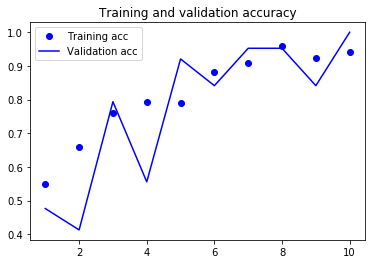

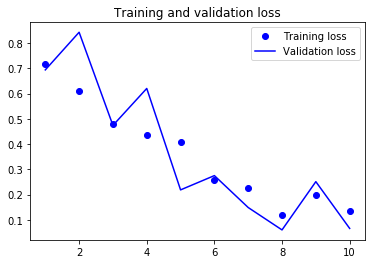

In [58]:
#画出结果
import matplotlib.pyplot as plt

#查看变量，发现history.history中就只有这四个值，分别是准确度，验证集准确度，损失，验证集损失
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#画两个图，分别是正确率和验证损失率
#正确率
plt.figure(1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('acc.png')
plt.show()
#损失
plt.figure(2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('loss.png')
plt.show()


In [59]:
#手动预测：
from PIL import ImageFilter
import sys
os.chdir(sys.path[0])
os.chdir("../../data/for_recognize/test/m")
os.system("ls *.jpg > names.txt")
os.chdir("../s")
os.system("ls *.jpg > names.txt")
os.chdir(sys.path[0])
with open("../../data/for_recognize/test/m/names.txt") as file:
    for line in file.readlines():
        if line=="":
            break;
        img = Image.open("../../data/for_recognize/test/m/"+line.strip("\n"))
        img = img.resize((imgSize,imgSize),Image.ANTIALIAS)
#         img = img.filter(ImageFilter.EDGE_ENHANCE)
#         img = img.filter(ImageFilter.DETAIL)
        img = img.filter(ImageFilter.RankFilter(5, 8))
        pred_value = model.predict(np.array(img).reshape((1,imgSize,imgSize,3))/255)[0]
        print("m predicted as: ",'m'if pred_value<0.5 else 's')
        
with open("../../data/for_recognize/test/s/names.txt") as file:
    for line in file.readlines():
        if line=="":
            break;
        img = Image.open("../../data/for_recognize/test/s/"+line.strip("\n"))
        img = img.resize((imgSize,imgSize),Image.ANTIALIAS)
#         img = img.filter(ImageFilter.EDGE_ENHANCE)
#         img = img.filter(ImageFilter.DETAIL)
        #img = img.convert('L').filter(ImageFilter.RankFilter(5, 8))
        img = img.filter(ImageFilter.RankFilter(5, 8))
        pred_value = model.predict(np.array(img).reshape((1,imgSize,imgSize,3))/255)[0]
        print("s predicted as: ",'m'if pred_value<0.5 else 's')

m predicted as:  m
m predicted as:  m
m predicted as:  m
m predicted as:  m
m predicted as:  m
m predicted as:  m
m predicted as:  m
m predicted as:  m
m predicted as:  m
m predicted as:  m
m predicted as:  m
m predicted as:  m
m predicted as:  m
m predicted as:  m
m predicted as:  m
m predicted as:  m
m predicted as:  m
m predicted as:  m
m predicted as:  m
m predicted as:  m
s predicted as:  s
s predicted as:  s
s predicted as:  s
s predicted as:  s
s predicted as:  s
s predicted as:  s
s predicted as:  s
s predicted as:  s
s predicted as:  s
s predicted as:  s
s predicted as:  s
s predicted as:  s
s predicted as:  s
s predicted as:  s
s predicted as:  s
s predicted as:  s
s predicted as:  s
s predicted as:  s
s predicted as:  s
s predicted as:  s
